<a href="https://colab.research.google.com/github/MishterBluesky/MIP/blob/master/Automatic_Weblogo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic 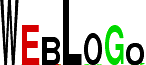

This colab workspace by Dr Chris LB Graham, Rodrigues lab allows for automatic conservation analysis, in the absence of the updated Weblogo and Consurf servers. Check run all and download the weblogo.png and .txt files to understand the most conserved residues.

It uses this gitlab - https://github.com/WebLogo/weblogo as well as Colabfold servers to generate the a3m files for alignment.



In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MLKKGPAVIG ATCLTSALLL SGCGLFQSDK AAEEIDPPQD VTFVNDEAGA NSNTTAAKKT ESEKSDTAKA DQASSTVMRE LYLIDKNGYV VAQTLPLPKS ESTAKQALEY LVQGGPVSEI LPNGFRAVLP ADTTVNVDIK  KDGTAIADFS NEFKNYKKED EQKIVQSVTW TLTQFSSIDK VKLRINGHEL KEMPVGGTPI SDDLSRKDGI NLETAGVNDL TATHPLTVYY LAENEDSEYY VPVTKRIDNS EKDDITAAIN ELAKGPSKVS GLLTDFSEDV  KLVSKPKIKD GRVTLDFNQS IFGSADEKTK MISSEVLNSI VLTLTEQPDV KSVSVKVNGK SELVNEKGEK LTEPVSRPSQ VNTGSF' #@param {type:"string"}

jobname = 'GerM' #@param {type:"string"}
# number of models to use
num_relax = 0

template_mode = "pdb100"


use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname GerM_2755a
sequence MLKKGPAVIGATCLTSALLLSGCGLFQSDKAAEEIDPPQDVTFVNDEAGANSNTTAAKKTESEKSDTAKADQASSTVMRELYLIDKNGYVVAQTLPLPKSESTAKQALEYLVQGGPVSEILPNGFRAVLPADTTVNVDIKKDGTAIADFSNEFKNYKKEDEQKIVQSVTWTLTQFSSIDKVKLRINGHELKEMPVGGTPISDDLSRKDGINLETAGVNDLTATHPLTVYYLAENEDSEYYVPVTKRIDNSEKDDITAAINELAKGPSKVSGLLTDFSEDVKLVSKPKIKDGRVTLDFNQSIFGSADEKTKMISSEVLNSIVLTLTEQPDVKSVSVKVNGKSELVNEKGEKLTEPVSRPSQVNTGSF
length 366


In [2]:
#@markdown ### Install Dependencies

%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version


if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

!python -m pip install --upgrade pip
!pip install tr-rosetta-pytorch
!apt-get install pymol
!touch TRROSETTA_READY

installing colabfold...
installing conda...
installing hhsuite...
  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 67.5 MB/s eta 0:00:00

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev2 libglu1-mesa libgudev-1.0-0 libinput-bin libinput10
  libmaloc1 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5 libqt5designer5 libqt5gui5 libqt5help5
  libqt5network5 libqt5opengl5 libqt5printsupport5 libqt5sql5 libqt5sql5-sqlite libqt5svg5
  libqt5test5 libqt5widgets5 libqt5xml5 libwacom-bin libwacom-common libwacom9 libxcb-icccm4
  libxcb-image0 libxcb-keysyms1 libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0
  libxcb-xkb1 libxkbcommon-x11-0 pymol-data python3-numpy python3-opengl python3-pymol
  python3-pyqt5 python3-pyqt5.qtopengl python3-pyqt5.sip qt5-gtk-platformtheme qttranslations5-l10n
Suggested packages:
  qt5-image-formats-plugins qtwayland5 python-numpy-doc python3-pytest libgle3
The following NEW packages will be installed:
  apbs apbs-data freeglut3 libapbs3 libevdev

In [27]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "1" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False
save_recycles = False
save_to_google_drive = False
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 300


if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

In [5]:
#@title Run Alignment
display_images = False

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=1,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=True,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

2023-10-31 13:08:18,981 Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
2023-10-31 13:08:18,982 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2023-10-31 13:08:23,938 Running on GPU
2023-10-31 13:08:24,097 Found 7 citations for tools or databases
2023-10-31 13:08:24,098 Query 1/1: GerM_2755a (length 366)
2023-10-31 13:08:24,099 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


2023-10-31 13:08:29,467 Sequence 0 found templates: ['6gzb_B', '6gzb_D', '6gz8_A', '6gzb_B', '5j7r_C', '6gzb_D', '6gzb_B', '6gzb_D', '5j7r_C', '6gz8_A']
2023-10-31 13:08:29,468 No user agent specified. Please set a user agent (e.g., 'toolname/version contact@email') to help us debug in case of problems. This warning will become an error in the future.
2023-10-31 13:08:30,653 Setting max_seq=512, max_extra_seq=1610
2023-10-31 13:10:24,382 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=82.6 pTM=0.766
2023-10-31 13:11:02,890 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.9 pTM=0.771 tol=3.78
2023-10-31 13:11:02,892 alphafold2_ptm_model_1_seed_000 took 132.2s (1 recycles)
2023-10-31 13:11:03,064 reranking models by 'plddt' metric
2023-10-31 13:11:03,065 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=82.9 pTM=0.771
2023-10-31 13:11:03,777 Done


0

2023-10-31 14:45:34,553 reset context of device 0
predictions for paired.aln saved to paired.npz
Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0



# All requested packages already installed.

Image loaded successfully. Dimensions: 627x947, Mode: RGB


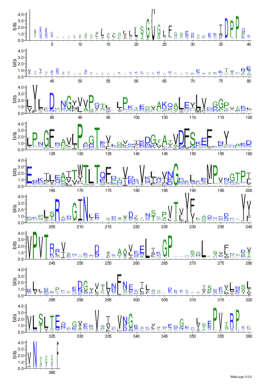

Contents of weblogo.txt:
## LogoData
# First column is position number, counting from zero
# Subsequent columns are raw symbol counts
# Entropy is mean entropy measured in nats.
# Low and High are the 95% confidence limits.
# Weight is the fraction of non-gap symbols in the column.
#	
#	A 	C 	D 	E 	F 	G 	H 	I 	K 	L 	M 	N 	P 	Q 	R 	S 	T 	V 	W 	Y 	Entropy	Low	High	Weight
1 	0 	0 	0 	0 	0 	0 	0 	0 	0 	0 	324 	0 	0 	0 	0 	0 	0 	0 	0 	0 	3.6254 	3.5499 	3.7009 	0.1674
2 	13 	6 	2 	0 	21 	6 	3 	9 	20 	34 	213 	7 	14 	10 	39 	107 	12 	6 	1 	12 	1.1182 	1.0069 	1.2296 	0.2765
3 	1 	0 	2 	1 	1 	5 	18 	2 	326 	0 	1 	117 	4 	33 	88 	14 	7 	0 	0 	4 	1.4410 	1.3476 	1.5345 	0.3225
4 	4 	1 	1 	1 	2 	4 	13 	18 	345 	6 	5 	59 	0 	8 	200 	11 	15 	6 	0 	11 	1.3484 	1.2542 	1.4426 	0.3669
5 	21 	0 	0 	1 	19 	31 	7 	22 	252 	11 	5 	18 	10 	11 	195 	26 	62 	2 	13 	26 	0.8630 	0.7760 	0.9499 	0.3783
6 	97 	0 	1 	0 	13 	41 	8 	72 	117 	31 	10 	24 	33 	17 	57 	42 	50 	39 	44 	8 	0.3327 	0.2739 	0.3916 	0.3638

In [28]:
#@title Run WebLogo: Conservation of protein{ display-mode: "form" }

os.chdir("/content")
import zipfile
import os

# Specify the file path and target folder
zip_file_path = f"/content/{jobname}/{jobname}.result.zip"  # Replace {jobname} with your job name
target_folder = "/content"

# Extract the contents of the ZIP file to the target folder
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

# List the contents of the target folder


!pip install numba
from numba import cuda
device = cuda.get_current_device()
device.reset()
os.chdir("/content")
!egrep -v '#|>' /content/{jobname}.a3m | sed 's/[a-z]//g' | sort -u > paired.aln
!tr_rosetta paired.aln
!conda install -c bioconda weblogo -y
!weblogo --format PNG < paired.aln > weblogo.png
!weblogo --format logodata < paired.aln > weblogo.txt
import matplotlib.pyplot as plt
from PIL import Image

# Provide the path to your uploaded image
image_path = '/content/weblogo.png'
image = Image.open(image_path)
width = 600
height = 1200
# Display image properties (width, height, mode)
width, height = image.size
mode = image.mode
print(f"Image loaded successfully. Dimensions: {width}x{height}, Mode: {mode}")
image.show()
import matplotlib.pyplot as plt

# Load and read the image using PIL or OpenCV
image_path = '/content/weblogo.png'
image = Image.open(image_path)  # Uncomment this line if using PIL

# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner look
plt.show()
weblogo_path = os.path.join(target_folder, "weblogo.txt")
if os.path.exists(weblogo_path):
    with open(weblogo_path, "r") as weblogo_file:
        weblogo_contents = weblogo_file.read()
        print("Contents of weblogo.txt:")
        print(weblogo_contents)
else:
    print("weblogo.txt not found in the extracted contents.")

In [30]:
#@title Package and download results
#@markdown This only downloads one model, unlike normal alphaFold, use the .pse file to determine if your interactions are true or not. If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

os.chdir(f"/content")
files.download("weblogo.png")
files.download("weblogo.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>